In [2]:
# pip install opencv-python


In [3]:
# pip install numpy

In [4]:
# Download YOLO files
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names


--2024-11-19 06:26:12--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  20.0MB/s    in 10s     

2024-11-19 06:28:42 (22.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-11-19 06:28:42--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

In [5]:
# Import required libraries
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow  # Special function for displaying images in Colab
import time

In [6]:
# Load YOLO
def load_yolo():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    with open("coco.names", "r") as f:
        classes = f.read().splitlines()
    return net, classes

In [7]:
# Function for object detection
def detect_objects(image, net, classes):
    height, width, _ = image.shape

    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    outputs = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w/2)
                y = int(center_y - h/2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = f"{classes[class_ids[i]]} {confidences[i]:.2f}"
            color = colors[class_ids[i]]

            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image

Loading YOLO model...
Model loaded successfully!
Please upload an image...


Saving d_b_c.jpg to d_b_c.jpg
Processing image: d_b_c.jpg
Detection completed in 4.09 seconds


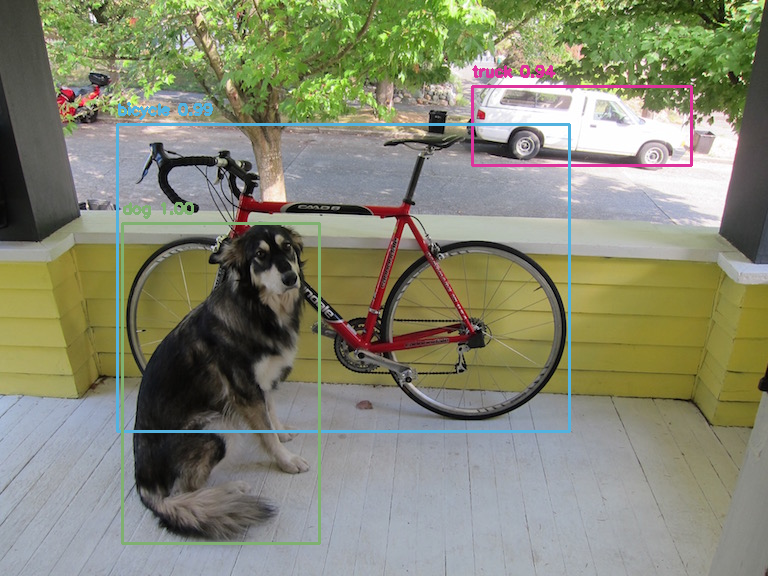

Result saved as 'result.jpg'


In [9]:
# Main execution
def main():
    print("Loading YOLO model...")
    net, classes = load_yolo()
    print("Model loaded successfully!")

    # Option to upload image
    print("Please upload an image...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing image: {filename}")

        # Read the uploaded image
        image_np = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)

        # Detect objects
        start_time = time.time()
        result = detect_objects(image_np, net, classes)
        end_time = time.time()

        print(f"Detection completed in {end_time - start_time:.2f} seconds")

        # Display result
        cv2_imshow(result)

        # Save result (optional)
        cv2.imwrite('result.jpg', result)
        print("Result saved as 'result.jpg'")

# Run the main function
if __name__ == "__main__":
    main()